<a href="https://colab.research.google.com/github/akankshakusf/Project-Fine-Tuned-LLMs-for-Product-Pricing/blob/master/Evaluate_My_Model_Predict_Product_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Predict Product Prices

### And now, to evaluate my  fine-tuned open source model

In [1]:
# pip installs
!pip install -q datasets \
                requests \
                torch \
                peft \
                bitsandbytes \
                transformers \
                trl \
                accelerate \
                sentencepiece\
                tiktoken \
                matplotlib

In [1]:
#import packages
import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,set_seed
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
from peft import PeftModel
import matplotlib.pyplot as plt

In [2]:
from ast import increment_lineno
#contants
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "pricer"
HF_USER = "akankshakusf"

#fine tuned model
RUN_NAME = "2025-05-02_20.00.01"
PROJECT_RUN_NAME =  f"{PROJECT_NAME}-{RUN_NAME}"
REVISION = "06fd8de24f06620967bc3748e3edc09a7437d44d"
###"5f1cd803dd15a87b779f73bc4061081e50e9e064" # or REVISION = None
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

#my data from hugging face
DATASET_NAME = f"{HF_USER}/pricer-data"


#hyperparameters for QLoRA
QUANT_4_BIT = True

%matplotlib inline

#used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [3]:
#log in to HuggingFace
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [4]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [5]:
#load dataset
dataset = load_dataset(DATASET_NAME)
train= dataset['train']
test = dataset['test']#define quantization needed
if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [13]:
# Load the Tokenizer and the Model
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Load the fine-tuned model with PEFT (parameter efficient fine tuning)
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

In [7]:
# Load the Tokenizer and the Model
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Load the fine-tuned model with PEFT (parameter efficient fine tuning)
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

# Inference

In [8]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [9]:
extract_price("Price is $a fabulous 899.99 or so")

899.99

In [10]:
#prdictor function
def model_predict(prompt):
  set_seed(42)
  inputs=tokenizer.encode(prompt, return_tensors="pt").to("cuda")
  attention_mask = torch.ones(inputs.shape, device="cuda")
  outputs = fine_tuned_model.generate(inputs,attention_mask = attention_mask, max_tokens = 3, num_return_sequences = 1)
  response = tokenizer.decode(outputs[0])
  return extract_price(response)

In [11]:
# An improved prediction function takes a weighted average of the top 3 choices
# This code would be more complex if we couldn't take advantage of the fact
# That Llama generates 1 token for any 3 digit number

top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors= "pt").to(device)
    attention_mask = torch.ones(inputs.shape,device= device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

In [12]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

# THE MOMENT OF TRUTH!

## Use the model in inference mode

Remember, GPT-4o had an average error of \$88.  
Llama 3.1 base model had an average error of \$436.   
This human had an error of \$127.  

1: Guess: $172.62 Truth: $140.49 Error: $32.13 SLE: 0.04 Item: Sena Bluetooth Heads...
2: Guess: $255.50 Truth: $347.99 Error: $92.49 SLE: 0.09 Item: ONINE Thruster Drop ...
3: Guess: $207.50 Truth: $228.00 Error: $20.50 SLE: 0.01 Item: Max Factory K-ON! Mi...
4: Guess: $32.69 Truth: $43.99 Error: $11.30 SLE: 0.08 Item: Gear Head RC 1/10 Sc...
5: Guess: $179.62 Truth: $117.25 Error: $62.38 SLE: 0.18 Item: lenovo ThinkCentre M...
6: Guess: $148.75 Truth: $107.99 Error: $40.76 SLE: 0.10 Item: Retractable Cargo Co...
7: Guess: $28.78 Truth: $52.99 Error: $24.21 SLE: 0.35 Item: Jiayouy Guitar Repai...
8: Guess: $44.94 Truth: $49.99 Error: $5.05 SLE: 0.01 Item: Spec-D Tuning Honda ...
9: Guess: $31.97 Truth: $73.00 Error: $41.03 SLE: 0.65 Item: Fuel Tank Float - SI...
10: Guess: $249.50 Truth: $249.00 Error: $0.50 SLE: 0.00 Item: KICKINGHORSE F130 CS...
11: Guess: $194.75 Truth: $249.99 Error: $55.24 SLE: 0.06 Item: Xiaomi Redmi Note 11...
12: Guess: $73.75 Truth: $78.29 Error: $4.54 SLE: 0

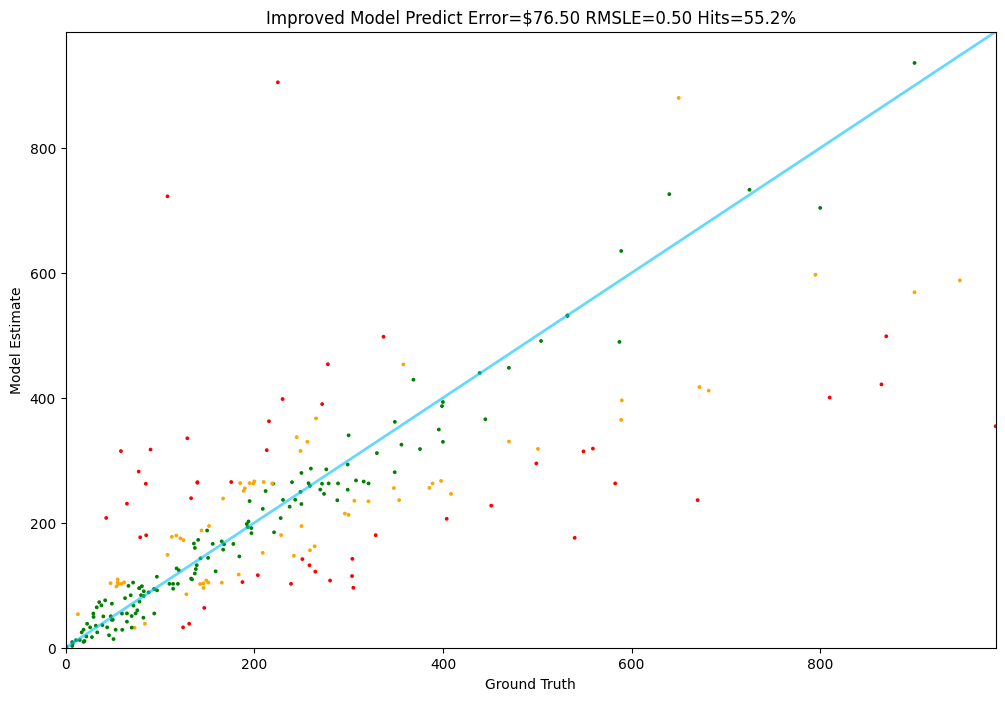

In [13]:
Tester.test(improved_model_predict, test)